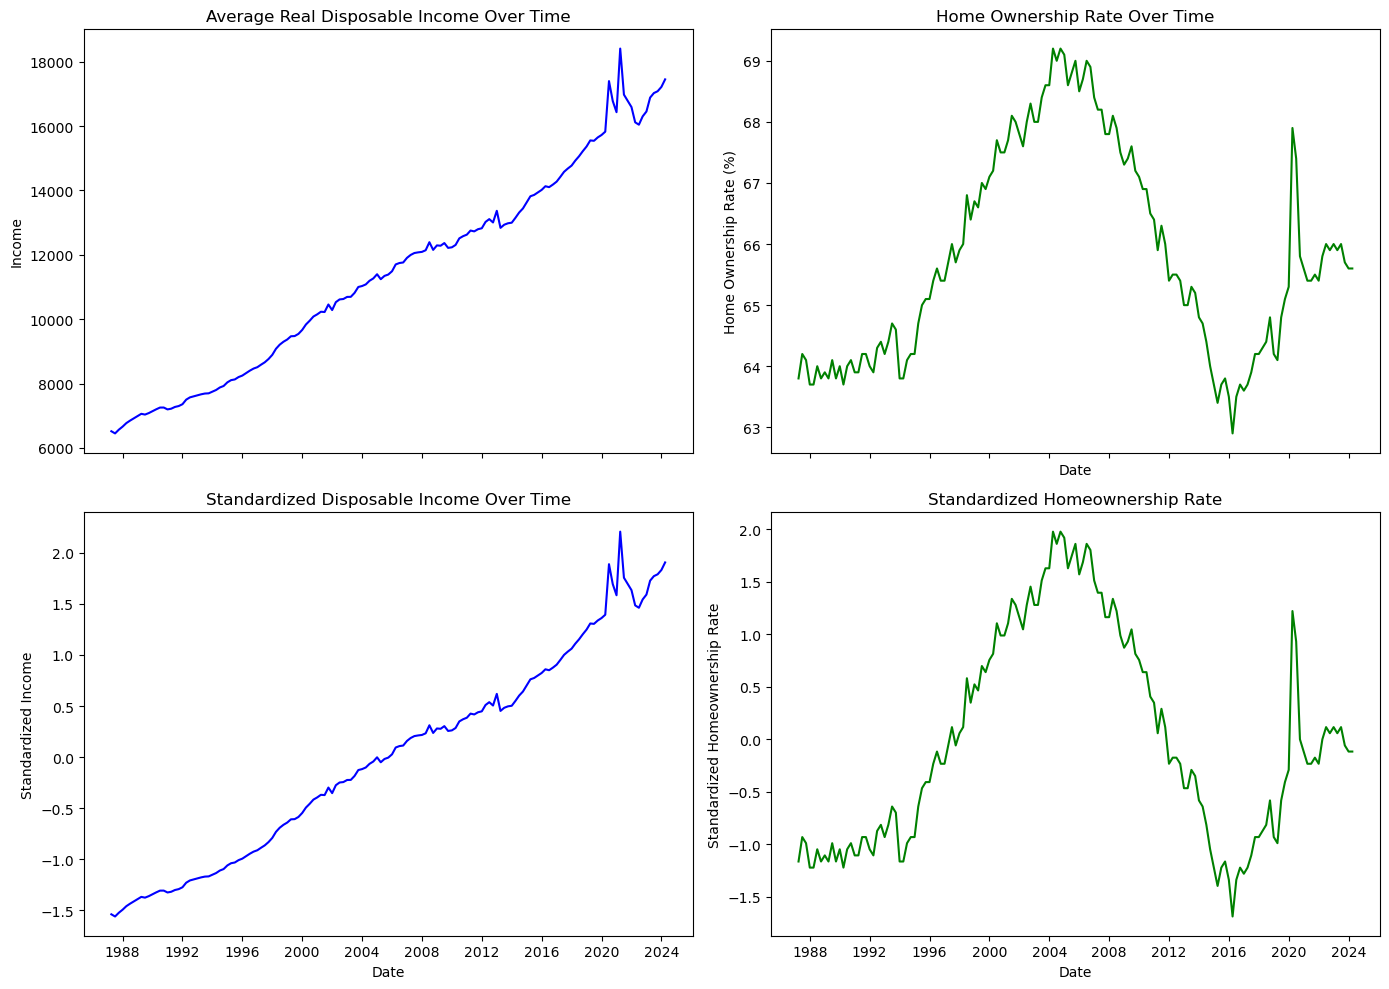

In [126]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
income_df = pd.read_csv('DSPIC96.csv', parse_dates=['DATE'])
home_ownership_df = pd.read_csv('RHORUSQ156N.csv', parse_dates=['DATE'])
home_price_index_df = pd.read_csv("CSUSHPINSA.csv", parse_dates=['DATE'])
consumer_debt_df = pd.read_csv("CDSP.csv", parse_dates=['DATE'])

# Resample income to quarterly if needed
income_df.set_index('DATE', inplace=True)
home_ownership_df.set_index('DATE', inplace=True)
home_price_index_df.set_index('DATE', inplace=True)
consumer_debt_df.set_index('DATE', inplace=True)

# Resample monthly data to quarterly using mean or forward fill methods
income_quarterly = income_df.resample('Q').mean()  # or use .ffill() for forward filling if preferable
home_price_index_quarterly = home_price_index_df.resample('Q').mean()

# Merge the datasets on the 'Date' index
income_quarterly.index = income_quarterly.index + pd.DateOffset(days=1)
home_price_index_quarterly.index = home_price_index_quarterly.index + pd.DateOffset(days=1)
merged_data = pd.merge(income_quarterly, home_ownership_df, on='DATE', how='inner')
merged_data = pd.merge(merged_data, home_price_index_quarterly, on='DATE', how='inner')
merged_data = pd.merge(merged_data, consumer_debt_df, on='DATE', how='inner')


merged_data['Income_std'] = (merged_data['DSPIC96'] - merged_data['DSPIC96'].mean()) / merged_data['DSPIC96'].std()
merged_data['HomeOwnershipRate_std'] = (merged_data['RHORUSQ156N'] - merged_data['RHORUSQ156N'].mean()) / merged_data['RHORUSQ156N'].std()
merged_data['HPIndex_std'] = (merged_data['CSUSHPINSA'] - merged_data['CSUSHPINSA'].mean()) / merged_data['CSUSHPINSA'].std()
merged_data['ConsumerDebtIndex_std'] = (merged_data['CDSP'] - merged_data['CDSP'].mean()) / merged_data['CDSP'].std()

# Plotting in separate subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharex=True)

# Plot Disposable Income
axs[0,0].plot(merged_data['DSPIC96'], color='blue')
axs[0,0].set_title("Average Real Disposable Income Over Time")
axs[0,0].set_ylabel("Income")

# Plot Home Ownership Rate
axs[0,1].plot(merged_data['RHORUSQ156N'], color='green')
axs[0,1].set_title("Home Ownership Rate Over Time")
axs[0,1].set_ylabel("Home Ownership Rate (%)")
axs[0,1].set_xlabel("Date")

axs[1,0].plot(merged_data['Income_std'], label="Standardized Disposable Income", color='blue')
axs[1,0].set_title("Standardized Disposable Income Over Time")
axs[1,0].set_ylabel("Standardized Income")
axs[1,0].set_xlabel("Date")

axs[1,1].plot(merged_data['HomeOwnershipRate_std'], label="Standardized Home Ownership Rate", color='green')
axs[1,1].set_title("Standardized Homeownership Rate")
axs[1,1].set_ylabel("Standardized Homeownership Rate")
axs[1,1].set_xlabel("Date")


plt.tight_layout()
plt.show()


ADF Statistic: -4.436840677298332
p-value: 0.0002553045637290202
Residuals are stationary (reject null hypothesis).


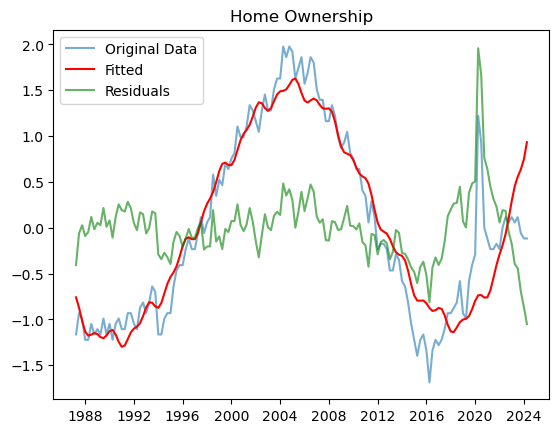

ADF Statistic: -4.275070304905831
p-value: 0.0004905024775002555
Residuals are stationary (reject null hypothesis).


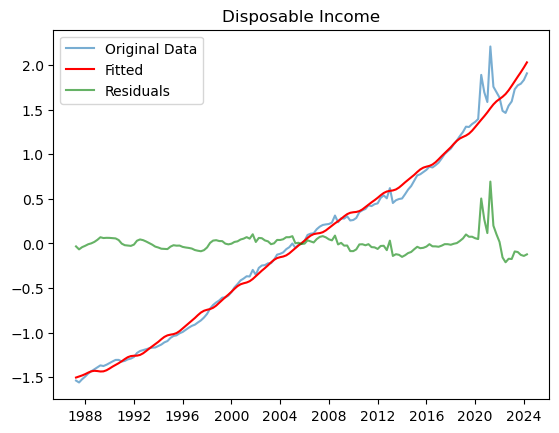

ADF Statistic: -4.215817913893027
p-value: 0.0006194335522808965
Residuals are stationary (reject null hypothesis).


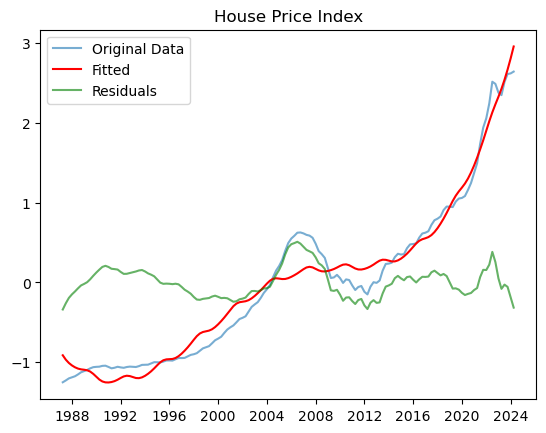

ADF Statistic: -3.444395801528945
p-value: 0.009535375847598114
Residuals are stationary (reject null hypothesis).


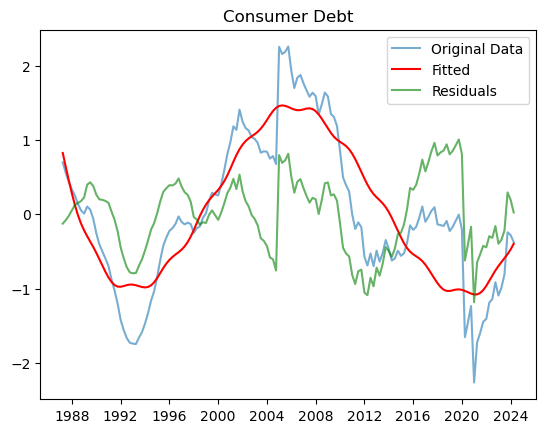

In [130]:
import numpy as np
import pandas as pd
from patsy import dmatrix
from statsmodels.tsa.statespace.tools import diff
from statsmodels.api import OLS
from scipy.stats import zscore
from statsmodels.tsa.stattools import adfuller


def make_stationary(series, label):
    data = series['data']
    # Step 1: Create a spline basis for trend
    time = np.arange(len(data))
    spline_basis = dmatrix("bs(time, df=5, degree=3, include_intercept=True)", {"time": time})

    # Step 2: Create Fourier terms for seasonality
    frequency = 12  # Assume monthly seasonality for this example
    k = 2  # Number of Fourier terms
    fourier_terms = np.column_stack([np.sin(2 * np.pi * time * j / frequency) for j in range(1, k + 1)] +
                                    [np.cos(2 * np.pi * time * j / frequency) for j in range(1, k + 1)])

    # Step 3: Combine trend and seasonality into a single model
    X = np.hstack([spline_basis, fourier_terms])  # Combine trend and seasonality
    model = OLS(data, X).fit()

    # Step 4: Calculate fitted values and residuals
    fitted_values = model.fittedvalues
    residuals = data - fitted_values

    # Step 5: Verify stationarity of residuals
    adf_result = adfuller(residuals)
    print("ADF Statistic:", adf_result[0])
    print("p-value:", adf_result[1])
    if adf_result[1] < 0.05:
        print("Residuals are stationary (reject null hypothesis).")
    else:
        print("Residuals are not stationary (fail to reject null hypothesis).")

    plt.plot(series['time'], data, label="Original Data", alpha=0.6)
    plt.plot(series['time'], fitted_values, label='Fitted', color="red")
    plt.plot(series['time'], residuals, label="Residuals", color="green", alpha=0.6)
    plt.legend()
    plt.title(label)
    plt.show()

    return residuals

# stationary data
merged_data = merged_data.reset_index()
merged_data['HomeOwnerStat'] = make_stationary(merged_data[['DATE', 'HomeOwnershipRate_std']].rename(columns={'HomeOwnershipRate_std': 'data', 'DATE': 'time'}), 'Home Ownership')
merged_data['IncomeStat'] = make_stationary(merged_data[['DATE', 'Income_std']].rename(columns={'Income_std': 'data', 'DATE': 'time'}), 'Disposable Income')
merged_data['HpStat'] = make_stationary(merged_data[['DATE', 'HPIndex_std']].rename(columns={'HPIndex_std': 'data', 'DATE': 'time'}), 'House Price Index')
merged_data['CDStat'] = make_stationary(merged_data[['DATE', 'ConsumerDebtIndex_std']].rename(columns={'ConsumerDebtIndex_std': 'data', 'DATE': 'time'}), 'Consumer Debt')

stationary_data = merged_data[['DATE', 'HomeOwnerStat', 'IncomeStat', 'HpStat', 'CDStat']]

In [125]:
merged_data

,level_0,index,DATE,DSPIC96,RHORUSQ156N,CSUSHPINSA,CDSP,Income_std,HomeOwnershipRate_std,HPIndex_std,ConsumerDebtIndex_std,HomeOwnerStat,IncomeStat,HpStat,CDStat
0,0,0,1987-04-01,6516.566667,63.8,64.111333,6.273851,-1.538210,-1.163624,-1.250092,0.698393,-0.405101,-0.034001,-0.338300,-0.125950
1,1,1,1987-07-01,6448.966667,64.2,65.577667,6.179090,-1.559502,-0.930977,-1.227209,0.555418,-0.059317,-0.067195,-0.260448,-0.079272
2,2,2,1987-10-01,6565.033333,64.1,67.225667,6.096414,-1.522945,-0.989139,-1.201492,0.430677,0.027012,-0.042327,-0.193193,-0.019930
3,3,3,1988-01-01,6659.733333,63.7,68.111333,6.031035,-1.493118,-1.221786,-1.187670,0.332034,-0.090518,-0.027154,-0.148595,0.054729
4,4,4,1988-04-01,6769.333333,63.7,68.939000,5.974719,-1.458598,-1.221786,-1.174754,0.247065,-0.045361,-0.009802,-0.112412,0.126704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,144,144,2023-04-01,16885.200000,65.9,294.665333,5.158004,1.727520,0.057771,2.347805,-0.985190,-0.394175,-0.090784,-0.079453,-0.342594
145,145,145,2023-07-01,17025.166667,66.0,305.245667,5.276051,1.771604,0.115933,2.512916,-0.807081,-0.441744,-0.097015,-0.026609,-0.216033
146,146,146,2023-10-01,17082.833333,65.7,311.611333,5.649808,1.789767,-0.058552,2.612255,-0.243159,-0.694305,-0.129215,-0.054789,0.293551
147,147,147,2024-01-01,17216.533333,65.6,312.091667,5.625271,1.831877,-0.116714,2.619751,-0.280180,-0.863981,-0.140724,-0.187542,0.193820


/Users/kevkoppa/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/kevkoppa/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/kevkoppa/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/kevkoppa/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/kevkoppa/anaconda3/lib/python3.11/si

Best ARIMA model order based on AIC: (1, 0, 2)
AIC: -495.6873047318277
Mean Squared Error of the best model: 0.037702850881899695


/Users/kevkoppa/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


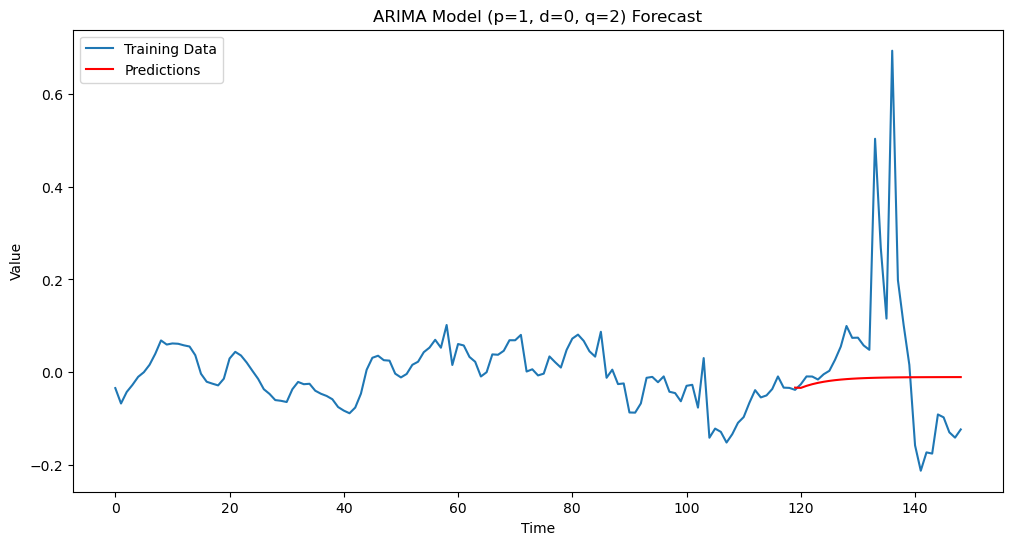

In [122]:
from statsmodels.tsa.arima.model import ARIMA
from itertools import product
import numpy as np

# Assuming `data_series` is your time series data
data_series = stationary_data['IncomeStat']
data_series = np.array(data_series)

# Split the data into training and testing
train_size = int(len(data_series) * 0.8)
train, test = data_series[:train_size], data_series[train_size:]

# Hyperparameter grid for (p, d, q) combinations
p_values = range(0, 4)  # 0 to 3
d_values = range(0, 3)  # 0 to 2 (often d = 0, 1, or 2)
q_values = range(0, 4)  # 0 to 3

best_aic = np.inf
best_order = None

# Loop over all combinations of p, d, q
for p, d, q in product(p_values, d_values, q_values):
    try:
        model = ARIMA(train, order=(p, d, q))
        results = model.fit()
        aic = results.aic
        if aic < best_aic:
            best_aic = aic
            best_order = (p, d, q)
    except:
        continue

print(f"Best ARIMA model order based on AIC: {best_order}")
print(f"AIC: {best_aic}")

# Train the best model
best_model = ARIMA(train, order=best_order)
best_results = best_model.fit()

# Forecast on the test set
predictions = best_results.forecast(len(test))

# Evaluate model
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test, predictions)
print(f"Mean Squared Error of the best model: {mse}")

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(data_series, label='Training Data')
plt.plot(np.arange(train_size, len(data_series)), predictions, label='Predictions', color='red')
plt.title(f"ARIMA Model (p={best_order[0]}, d={best_order[1]}, q={best_order[2]}) Forecast")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()

In [115]:
from statsmodels.stats.diagnostic import het_breuschpagan
from arch.unitroot import ARCH

# Perform the Breusch-Pagan test on the squared data
arch_test = ARCH(endog=data_series, lags=1)  # 1 lag is typically used
statistic, p_value, _ = arch_test.fit()

ImportError: cannot import name 'ARCH' from 'arch.unitroot' (/Users/kevkoppa/anaconda3/lib/python3.11/site-packages/arch/unitroot/__init__.py)

It seems like the data, despite making it stationary, has a spike in volatility around the 2020-2022 time window. This spike is due to the rise in disposable income during the COVID-19 pandemic when government aid increased spending dollars for Americans. Because of this, the results of the ARIMA-GARCH/ARIMA model depends on the train-test intervals chosen. For example, by setting the training interval to 95% of the data, the models will not predict over the 2020-2022 window. This leads to the models having data fall between the projected confidence bands. On the other hand, an 80-20 split means the models must predict the large spike in disposable income. This spike makes the data hard to predict. Consequently, the data exists outside the confidence bands of both ARIMA and ARIMA-GARCH. 
In order to account for this spike in volatility, we can use GARCH model for modeling the volatility of the data. 

Iteration:      1,   Func. Count:      6,   Neg. LLF: 683527.525668589
Iteration:      2,   Func. Count:     16,   Neg. LLF: -165.77765976197335
Iteration:      3,   Func. Count:     22,   Neg. LLF: 297702.3538717521
Iteration:      4,   Func. Count:     28,   Neg. LLF: -196.0795743920173
Iteration:      5,   Func. Count:     33,   Neg. LLF: -196.50675505119145
Iteration:      6,   Func. Count:     39,   Neg. LLF: -188.96468233942542
Iteration:      7,   Func. Count:     46,   Neg. LLF: -66.32855415668683
Iteration:      8,   Func. Count:     52,   Neg. LLF: -197.55705658091463
Iteration:      9,   Func. Count:     57,   Neg. LLF: -197.51517117411674
Iteration:     10,   Func. Count:     63,   Neg. LLF: -197.5840087664437
Iteration:     11,   Func. Count:     68,   Neg. LLF: -197.58466825261246
Iteration:     12,   Func. Count:     73,   Neg. LLF: -197.5846962034397
Iteration:     13,   Func. Count:     77,   Neg. LLF: -197.58469620346122
Optimization terminated successfully    (Exit m

/Users/kevkoppa/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/kevkoppa/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002883. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


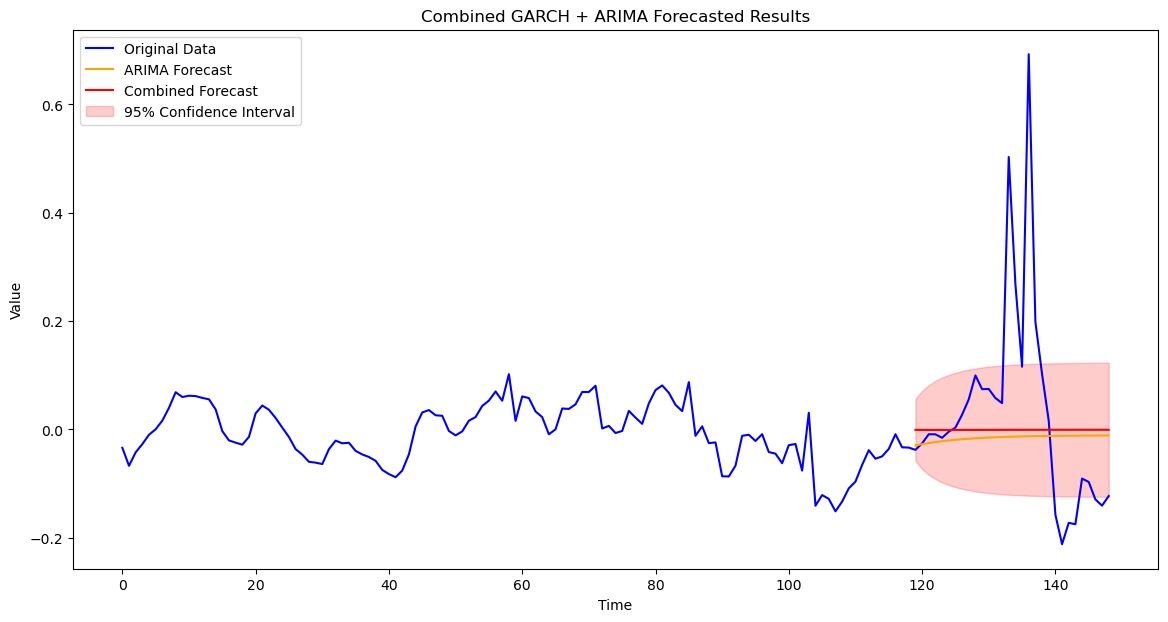

In [123]:
from arch import arch_model
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Assuming 'returns' is your time series of returns
returns = np.array(train)

# Fit ARIMA model
arima_order = (1, 0, 1)  # Example ARIMA order (p,d,q)
arima_model = ARIMA(returns, order=arima_order)
arima_results = arima_model.fit()
arima_forecast = arima_results.forecast(steps=30)

# Fit GARCH model
garch_model = arch_model(returns, vol='Garch', p=1, q=1)
garch_results = garch_model.fit()
forecast = garch_results.forecast(horizon=30)

# Extract forecasted variances from GARCH
forecasted_variances = forecast.variance

# Combining ARIMA and GARCH forecasts
combined_forecast = np.array(arima_forecast * np.sqrt(forecasted_variances)).ravel()

# Plotting combined forecast
plt.figure(figsize=(14, 7))

# Plot original data
plt.plot(data_series, label='Original Data', color='blue')

# Plot ARIMA forecasted values
plt.plot(np.arange(len(returns), len(returns) + len(arima_forecast)), arima_forecast, label='ARIMA Forecast', color='orange')

# Plot combined forecasted values
plt.plot(np.arange(len(returns), len(returns) + len(combined_forecast)), combined_forecast, label='Combined Forecast', color='red')

# Add confidence intervals (95% confidence)
lower_bound = combined_forecast - 1.96 * np.sqrt(forecasted_variances)
upper_bound = combined_forecast + 1.96 * np.sqrt(forecasted_variances)
plt.fill_between(np.arange(len(returns), len(returns) + len(combined_forecast)),
                 np.array(lower_bound).ravel(),
                 np.array(upper_bound).ravel(),
                 color='red',
                 alpha=0.2,
                 label='95% Confidence Interval')

plt.title("Combined GARCH + ARIMA Forecasted Results")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()

In [109]:
combined_forecast

array([-0.00086657, -0.00100595, -0.00106484, -0.00108256, -0.0010775 ,
       -0.00105974, -0.0010352 , -0.00100749, -0.00097883, -0.0009506 ])